In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np
import warnings
import sys
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# importing scripts
sys.path.insert(1, '../scripts')

from vizualisation import Data_Viz
from cleaning import DataCleaner
from transformation import DataTransformer

dv = Data_Viz()
dc = DataCleaner()
dt = DataTransformer()


In [4]:
# importing datasets
sample_df = pd.read_csv("../data/submission.csv")
store_df = pd.read_csv("../data/store.csv")
test_df = pd.read_csv("../data/test.csv")
train_df = pd.read_csv("../data/train.csv")

In [5]:
# checking sample dataset
sample_df.head()

,Id,Sales
0,879066,5250.649414
1,37135,5997.647461
2,285919,9207.910156
3,744348,12377.560547
4,556250,5296.302734


In [6]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [8]:
# replacing empty values with 0 and -
store_clean = store_df.copy(deep=True)
store_clean['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(0)
store_clean['Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(0)
store_clean['PromoInterval'] = store_df['PromoInterval'].fillna('-')

In [9]:
# removing columns with more than 30% missing value
store_clean = dc.reduce_dim_missing(store_clean, 30)
store_clean

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,0,0.0,0.0,-
1,2,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,0,0.0,0.0,-
4,5,a,a,29910.0,0,0.0,0.0,-
...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,0,0.0,0.0,-
1112,1113,a,c,9260.0,0,0.0,0.0,-
1113,1114,a,c,870.0,0,0.0,0.0,-


In [10]:
# checking cleaned data 
dv.summ_columns(store_clean)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Store,0,0.0,int64,1115
1,StoreType,0,0.0,object,4
2,Assortment,0,0.0,object,3
3,CompetitionDistance,3,0.0,float64,655
4,Promo2,0,0.0,int64,2
5,Promo2SinceWeek,0,0.0,float64,25
6,Promo2SinceYear,0,0.0,float64,8
7,PromoInterval,0,0.0,object,4



- sales and customers have outliers

In [12]:
# a pipeline to handle missing values and outliers.
pipe = Pipeline(steps=[ ("Handle numerical missing values", FunctionTransformer(dc.fill_missing_by_median)),
                        ("Handle categorical missing values", FunctionTransformer(dc.fill_missing_by_mode)),
                        ("Handle outlier", FunctionTransformer(dc.fill_outliers_mean, kw_args={'cols':['Sales', 'Customers']}))])

In [13]:
# running the train dataset in the cleaning pipe

train_store_clean = pipe.fit_transform(train_df)

train_store_clean

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-17,4852.0,519.0,1,1,0,0,303445
1,2,5,2015-07-17,4518.0,495.0,1,1,0,1,959585
2,3,5,2015-07-17,6679.0,673.0,1,1,0,1,739744
3,4,5,2015-07-17,10514.0,1343.0,1,1,0,1,864001
4,5,5,2015-07-17,4355.0,513.0,1,1,0,1,981931
...,...,...,...,...,...,...,...,...,...,...
1001594,1111,2,2013-01-01,0.0,0.0,0,0,a,1,225066
1001595,1112,2,2013-01-01,0.0,0.0,0,0,a,1,775592
1001596,1113,2,2013-01-01,0.0,0.0,0,0,a,1,135205
1001597,1114,2,2013-01-01,0.0,0.0,0,0,a,1,954751


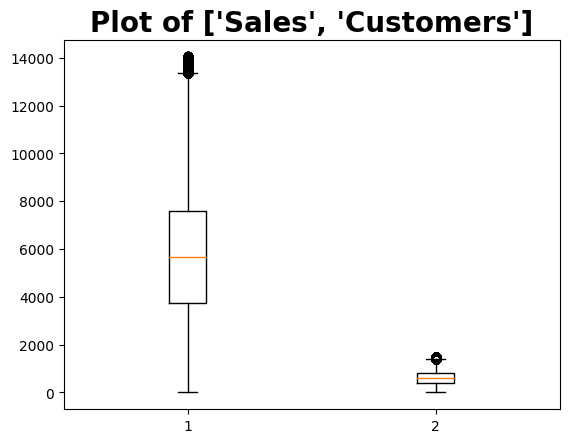

In [14]:
# checking if outliers are handled

dv.plot_box2(train_store_clean, ['Sales', 'Customers'])

ARE PROMOTIONS DISTRIBUTED SIMILARLY BETWEEN TRAIN AND TEST SET

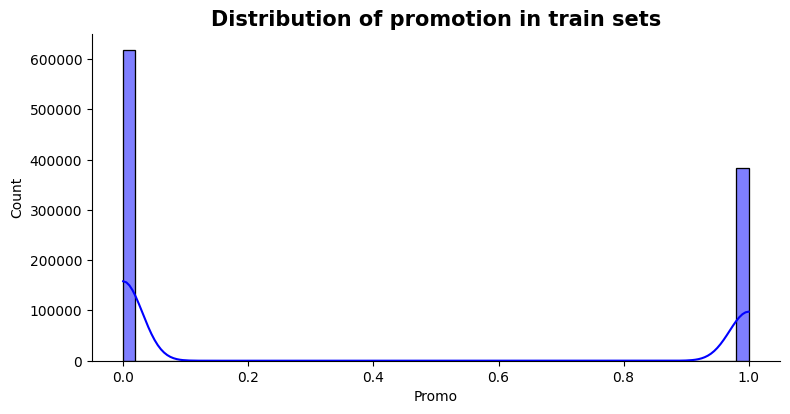

In [15]:
dv.show_distribution(train_df, 'Promo', 'blue', "Distribution of promotion in train sets")


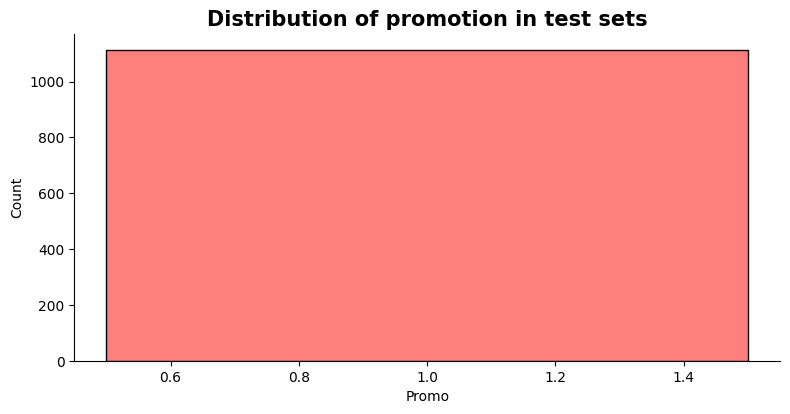

In [16]:
dv.show_distribution(test_df, 'Promo', 'red', "Distribution of promotion in test sets")

* in train set there tends to be more no promotion than test set 

SALES VS. HOLIDAY

In [17]:
train_df['StateHoliday'].value_counts().index

Index(['0', 0, 'a', 'b', 'c'], dtype='object')

one of the 0 is string while the other is integer, let's change the int-type to str and so that we won't have different 0 plots

In [18]:
dc.replace_rows_str(train_df, "StateHoliday")

Index(['0', 'a', 'b', 'c'], dtype='object')

In [19]:
dc.rename(train_df, "StateHoliday", '0', 'No_holiday')
dc.rename(train_df, "StateHoliday", 'a', 'Public holiday')
dc.rename(train_df, "StateHoliday", 'b', 'Easter')
dc.rename(train_df, "StateHoliday", 'c', 'Christmas')

Index(['No_holiday', 'Public holiday', 'Easter', 'Christmas'], dtype='object')

In [20]:
# merging dataset train and store
train_store = pd.merge(train_df, store_clean, how = 'left', on = "Store")

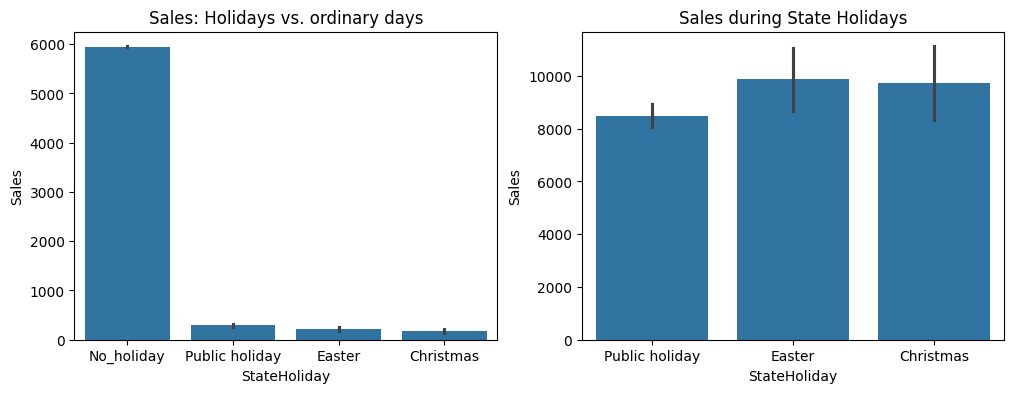

In [21]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,4))

# holidays and no_holidays
sns.barplot(x='StateHoliday', y='Sales', data=train_df, ax=axis1).set_title('Sales: Holidays vs. ordinary days')

holidays = train_df.query("StateHoliday != 'No_holiday'")
# holidays only
mask = (holidays["StateHoliday"] != "0") & (holidays["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=holidays[mask], ax=axis2).set_title('Sales during State Holidays')
plt.show()

* comparing no holidays vs. state holidays the purchase during no holidays is more
* comparing the purchase behavior between state holidays: Easter has more purchase, wile public holiday has less purchase

CORRELATION BETWEEN SALES AND CUSTOMERS

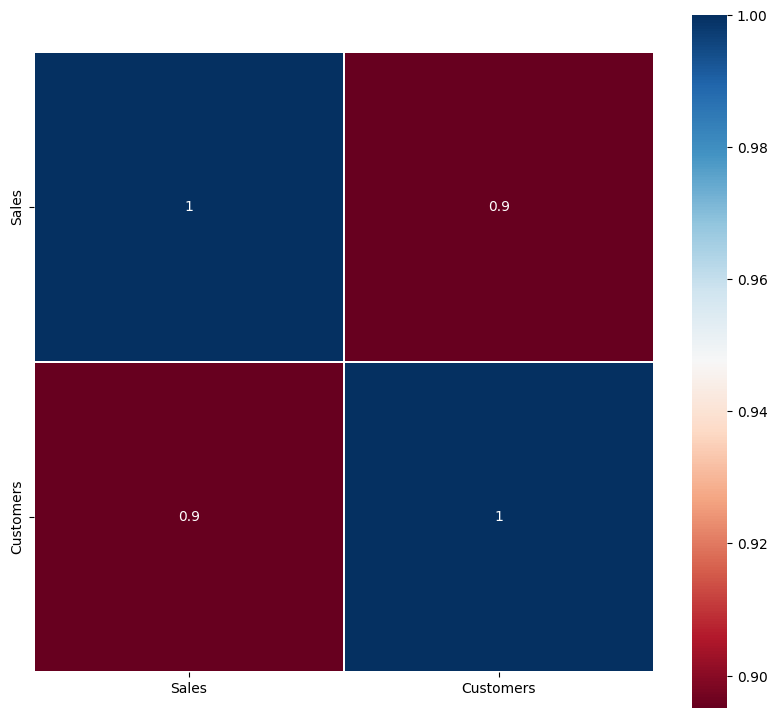

In [23]:
sales_customers = train_df[['Sales', 'Customers']]
dv.heat_map(sales_customers)

* the correlation between customers and sales is pretty positive, since in relation to one another they are close to one
* as sales increases so does the customer and vice versa

DOES PROMO AFFECT SALES AND CUSTOMERS?

In [24]:
promo_sales = train_df[['Sales', 'Promo']]

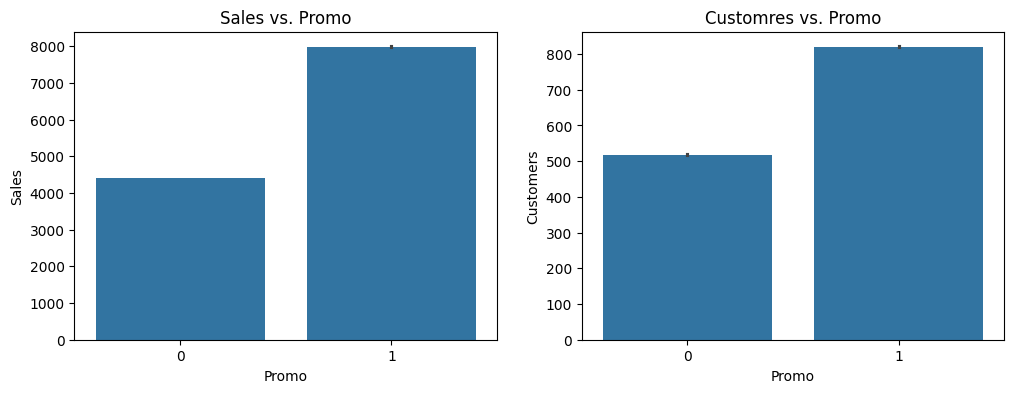

In [25]:
dv.two_barplot(promo_sales, train_df, 'Promo', 'Sales', 'Sales vs. Promo', 'Promo', 'Customers', 'Customres vs. Promo')

* as the plot shows, sales is higher when there is promotion than when there is not
* more customers are there with promotion than no promotion

STORES TO DEPLOY PROMOS

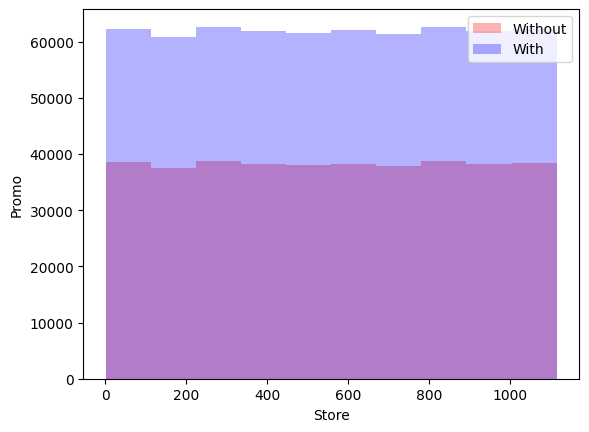

In [26]:
dv.plot_counts2(train_store_clean, 'Promo', 'Store')

* Promos should be done deployed in stores that are between 40,000 to 60,000

TRENDS OF CUSTOMERS DURING STORE OPENED AND STORE CLOSED

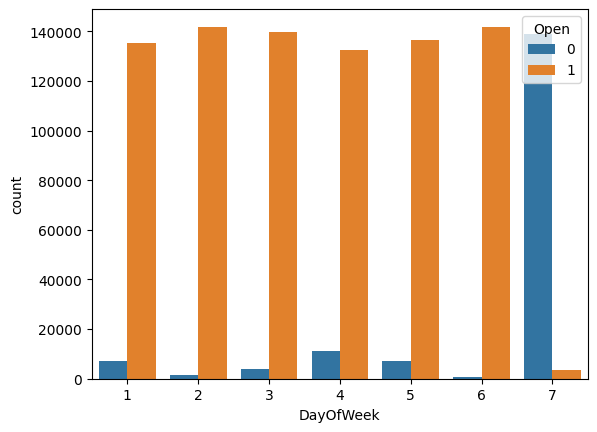

In [27]:
dv.plot_counts(train_df, 'DayOfWeek', 'Open')


* majority of stores open upto Saturday, 
* Saturday has the least closed store number, it might be because more customers are availiable from Monday to Friday, epecially Saturday

STORES OPEN OR CLOSED ACROSS THE WEEK AND WEEK DAYS

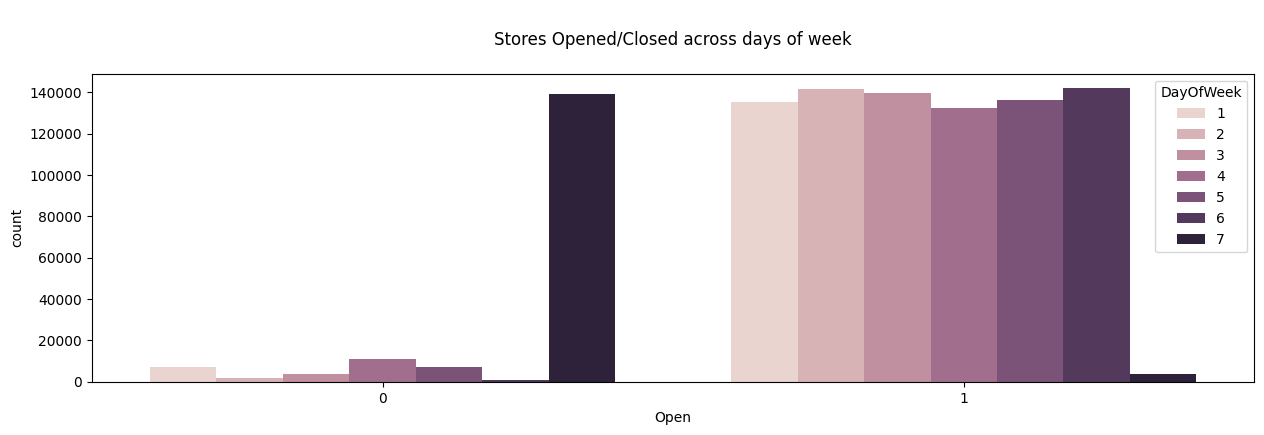

In [28]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=train_df, ax=axis1).set_title('\nStores Opened/Closed across days of week\n')
plt.show()

ASSORTMENT VS. SALES

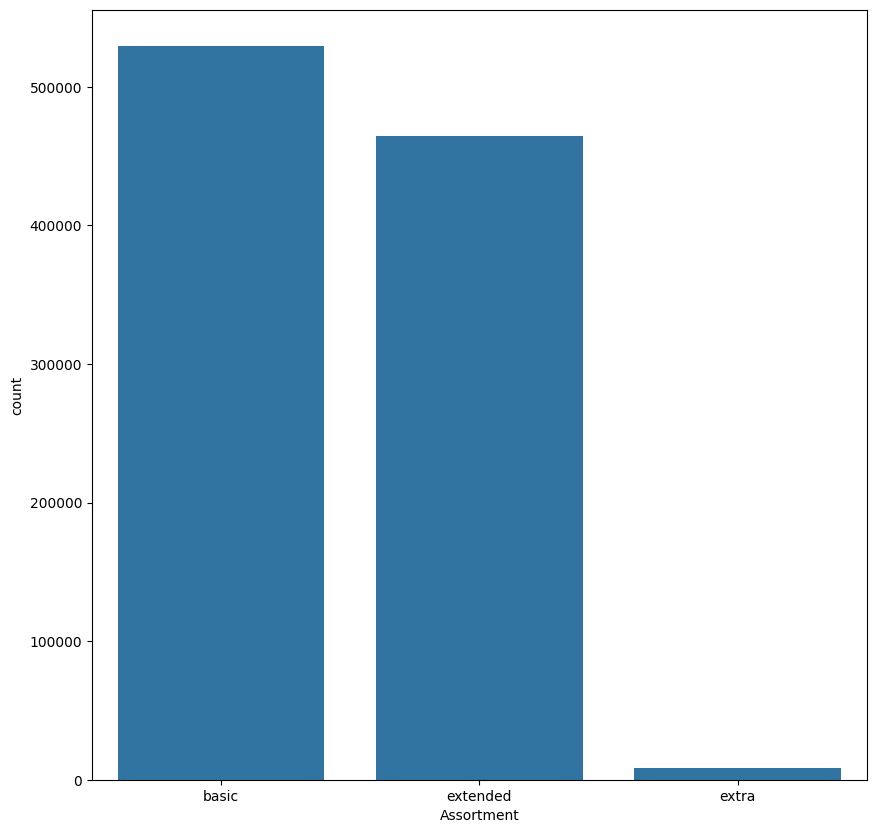

In [29]:
dc.rename(train_store, "Assortment", 'a', 'basic')
dc.rename(train_store, "Assortment", 'b', 'extra')
dc.rename(train_store, "Assortment", 'c', 'extended')
cols = ['Assortment', 'Sales']
dv.barplot(train_store, cols, 'Assortment')

* in accordance to assortmet type, the basic category have the most saless, extended assortment is the second and extra being the third

DISTANCE TO NEXT COMPETITORS

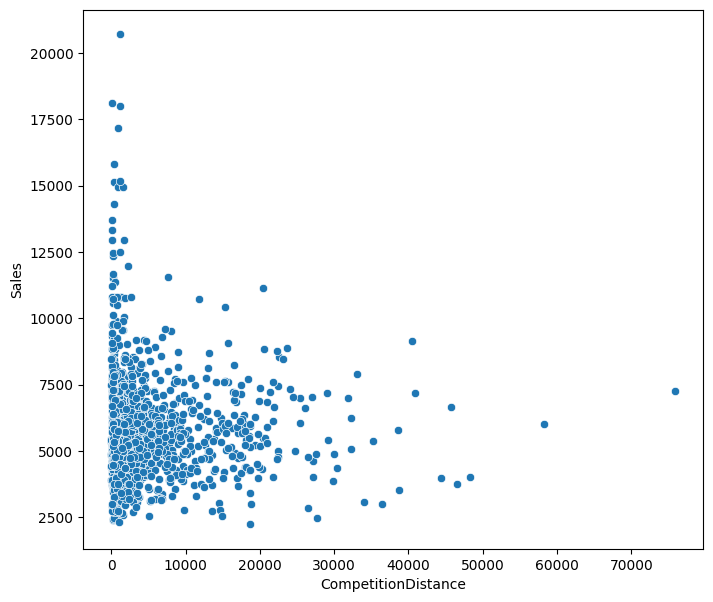

In [31]:
compet = train_store.groupby('Store').agg({
    'CompetitionDistance': 'mean',
    'Sales': 'mean',
    'Customers': 'mean'
})
plt.subplots(figsize = (8, 7))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=compet)
plt.show()

* the distance to the next competitor affects sales, the more there is sales in next competitors the less the sales is on the next of next competitor

[]

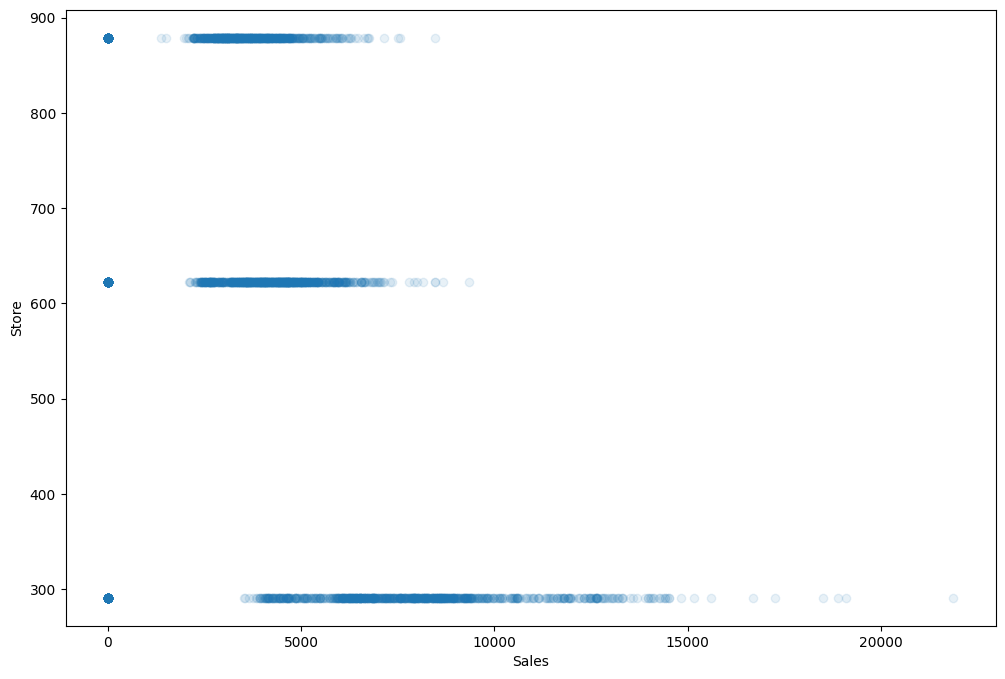

In [33]:
plt.figure(figsize=(12, 8))
plt.scatter(new_competitors['Sales'], new_competitors['Store'], alpha=0.1)
plt.xlabel('Sales')
plt.ylabel('Store')
plt.plot()

* in the above plot it looks like sales when opening and reopening is slow at first but it looks to grow over time.
* it might be due to attracting customers to these stores. 
* it looks like store 291 has more luck in sales, the least being store 879.

In [14]:
# creating new features

def convert_to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col])

convert_to_datetime(train_store_clean, ['Date'])

train_store_clean['Holiday'] = np.where(train_store_clean['StateHoliday']=='No_holiday', 0, 1)
train_store_clean['Year'] = train_store_clean['Date'].apply(lambda x: x.year)
train_store_clean['Month'] = train_store_clean['Date'].apply(lambda x: x.month)
train_store_clean['DayOfMonth'] = train_store_clean['Date'].apply(lambda x: x.day)
train_store_clean['WeekOfYear'] = train_store_clean['Date'].apply(lambda x: x.weekofyear)
train_store_clean['weekday'] = train_store_clean['DayOfWeek'].apply(lambda x: 0 if (x in [6, 7]) else 1)
train_store_clean['month_season'] = train_store_clean['DayOfMonth'].apply(lambda x: 0 if (x < 8) else (2 if(x > 21) else 1))
train_store_clean['year_season'] = train_store_clean['Month'].apply(lambda x: 0 if(x<4) else(1 if(x>3 and x<7) 
                                                                    else(2 if(x>6 and x<10) else 3)))

In [15]:
dv.summ_columns(train_store_clean)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Store,0,0.0,int64,1115
1,DayOfWeek,0,0.0,int64,7
2,Date,0,0.0,datetime64[ns],928
3,Sales,0,0.0,float64,13192
4,Customers,0,0.0,float64,1427
5,Open,0,0.0,int64,2
6,Promo,0,0.0,int64,2
7,StateHoliday,0,0.0,object,5
8,SchoolHoliday,0,0.0,int64,2
9,Id,0,0.0,int64,637137


In [17]:
train_store_clean.to_csv("../data/features.csv")